# 自动微分
:label:`sec_autograd`

正如 :numref:`sec_calculus`中所说，求导是几乎所有深度学习优化算法的关键步骤。
虽然求导的计算很简单，只需要一些基本的微积分。
但对于复杂的模型，手工进行更新是一件很痛苦的事情（而且经常容易出错）。

深度学习框架通过自动计算导数，即*自动微分*（automatic differentiation）来加快求导。
实际中，根据设计好的模型，系统会构建一个*计算图*（computational graph），
来跟踪计算是哪些数据通过哪些操作组合起来产生输出。
自动微分使系统能够随后反向传播梯度。
这里，*反向传播*（backpropagate）意味着跟踪整个计算图，填充关于每个参数的偏导数。

## 一个简单的例子

作为一个演示例子，(**假设我们想对函数$y=2\mathbf{x}^{\top}\mathbf{x}$关于列向量$\mathbf{x}$求导**)。
首先，我们创建变量`x`并为其分配一个初始值。


In [9]:
import tensorflow as tf

x = tf.range(4, dtype=tf.float32)
x

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 1., 2., 3.], dtype=float32)>

[**在我们计算$y$关于$\mathbf{x}$的梯度之前，需要一个地方来存储梯度。**]
重要的是，我们不会在每次对一个参数求导时都分配新的内存。
因为我们经常会成千上万次地更新相同的参数，每次都分配新的内存可能很快就会将内存耗尽。
注意，一个标量函数关于向量$\mathbf{x}$的梯度是向量，并且与$\mathbf{x}$具有相同的形状。


In [10]:
x = tf.Variable(x)

(**现在计算$y$。**)


In [11]:
# 把所有计算记录在磁带上
with tf.GradientTape() as t:
    y = 2 * tf.tensordot(x, x, axes=1)
y

<tf.Tensor: shape=(), dtype=float32, numpy=28.0>

`x`是一个长度为4的向量，计算`x`和`x`的点积，得到了我们赋值给`y`的标量输出。
接下来，[**通过调用反向传播函数来自动计算`y`关于`x`每个分量的梯度**]，并打印这些梯度。


In [12]:
x_grad = t.gradient(y, x)
x_grad

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.,  4.,  8., 12.], dtype=float32)>

函数$y=2\mathbf{x}^{\top}\mathbf{x}$关于$\mathbf{x}$的梯度应为$4\mathbf{x}$。
让我们快速验证这个梯度是否计算正确。


In [13]:
x_grad == 4 * x

<tf.Tensor: shape=(4,), dtype=bool, numpy=array([ True,  True,  True,  True])>

[**现在计算`x`的另一个函数。**]


In [14]:
with tf.GradientTape() as t:
    y = tf.reduce_sum(x)
t.gradient(y, x)  # 被新计算的梯度覆盖

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>

## 非标量变量的反向传播

当`y`不是标量时，向量`y`关于向量`x`的导数的最自然解释是一个矩阵。
对于高阶和高维的`y`和`x`，求导的结果可以是一个高阶张量。

然而，虽然这些更奇特的对象确实出现在高级机器学习中（包括[**深度学习中**]），
但当调用向量的反向计算时，我们通常会试图计算一批训练样本中每个组成部分的损失函数的导数。
这里(**，我们的目的不是计算微分矩阵，而是单独计算批量中每个样本的偏导数之和。**)


In [15]:
with tf.GradientTape() as t:
    y = x * x
print(y)
t.gradient(y, x)  # 等价于y=tf.reduce_sum(x*x)

tf.Tensor([0. 1. 4. 9.], shape=(4,), dtype=float32)


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 2., 4., 6.], dtype=float32)>

## 分离计算

有时，我们希望[**将某些计算移动到记录的计算图之外**]。
例如，假设`y`是作为`x`的函数计算的，而`z`则是作为`y`和`x`的函数计算的。
想象一下，我们想计算`z`关于`x`的梯度，但由于某种原因，希望将`y`视为一个常数，
并且只考虑到`x`在`y`被计算后发挥的作用。

这里可以分离`y`来返回一个新变量`u`，该变量与`y`具有相同的值，
但丢弃计算图中如何计算`y`的任何信息。
换句话说，梯度不会向后流经`u`到`x`。
因此，下面的反向传播函数计算`z=u*x`关于`x`的偏导数，同时将`u`作为常数处理，
而不是`z=x*x*x`关于`x`的偏导数。


In [23]:
# 设置persistent=True来运行t.gradient多次
with tf.GradientTape(persistent=True) as t:
    y = x * x               # y = x^2（记录计算图）
    u = tf.stop_gradient(y) # u的值等于y，但梯度回传时阻断u到y的路径
    z = u * x               # z = x^3（数学上），但梯度计算时视为 z = (常数u) * x

x_grad = t.gradient(z, x)   # x_grad = \frac{\partial{ux}}{x} = (常数u) = (特定的运算结果x^2)
x_grad == u

<tf.Tensor: shape=(4,), dtype=bool, numpy=array([ True,  True,  True,  True])>

由于记录了`y`的计算结果，我们可以随后在`y`上调用反向传播，
得到`y=x*x`关于的`x`的导数，即`2*x`。

In [24]:
t.gradient(y, x) == 2 * x

<tf.Tensor: shape=(4,), dtype=bool, numpy=array([ True,  True,  True,  True])>

（mio）为了更好的理解这部分内容，下面是我绘制的该过程的示意图：

![分离计算阻断传播的示意图](../img/detaching-computation.svg)

其中实线描述了正向计算路径，虚线描述了反向传播的路径。如果你正在使用 Pycharm 阅读这份文档，你可能会遇到图片无法正常加载的问题，可以去掉下面代码块的包裹获取图片：

```html
<img src="https://mermaid.ink/svg/pako:eNqNks9L40AUx_-Vx4iSSqJg7aGR3ZPHPSmFNgSWMTNpgslMSGYw0XgRDy7s6u5eFhVkV8Gb9ahIcf-XxdTe-i_s2Ka1igffYXg_Pt_33gyzgxxOKDLR7Cz0O38eO7-K0_uH28Pe-XVxd_nQ_d37edW_uS7u9wfdg97VRfH9x6B7UnTOHu_-Drpfi6Nvo0z_-GSY-WKzdowjDz6t2QyUJXJjlCBUYMfzWdtweBhJgYXP2Yh5sqampZUKGMbHPIV5SHNoaVpWqTwTrWFRwgfIcmhompwuNmEOGiUwVFuatj0NWGAsqOq_g73tRXWkqo3MofkKSPNE8Oiz2pj4lAk15xlovAm0XixYjsjGI5bSyQzKiF3eNxFZQFU_1w8Cc8atu3oiYr5JzZlqtVr6xpZPhGcuRem0xio1dbf-Do0T4CRZpS5sBNzZpARKjODEw3GMMxNqUJs0cpeXV6aE0NBbujXWqgrSUUjjEPtE_ZedJ9JGwqMhtZGpXEJdLANhI5vtKhRLwdcz5iBTxJLqKOay7SHTxUGiIhkRLOiqj9VLhpNshJnF-Tje_Q_sf-4l" alt="分离计算阻断传播的示意图" width="300" height="200">
```

## Python控制流的梯度计算

使用自动微分的一个好处是：
[**即使构建函数的计算图需要通过Python控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度**]。
在下面的代码中，`while`循环的迭代次数和`if`语句的结果都取决于输入`a`的值。


In [25]:
def f(a):
    b = a * 2
    while tf.norm(b) < 1000:
        b = b * 2
    if tf.reduce_sum(b) > 0:
        c = b
    else:
        c = 100 * b
    return c

让我们计算梯度。


In [47]:
a = tf.Variable(tf.random.normal(shape=()))
with tf.GradientTape() as t:
    d = f(a)
d_grad = t.gradient(d, a)
d_grad

<tf.Tensor: shape=(), dtype=float32, numpy=409600.0>

我们现在可以分析上面定义的`f`函数。
请注意，它在其输入`a`中是分段线性的。
换言之，对于任何`a`，存在某个常量标量`k`，使得`f(a)=k*a`，其中`k`的值取决于输入`a`，因此可以用`d/a`验证梯度是否正确。


In [27]:
d_grad == d / a

<tf.Tensor: shape=(), dtype=bool, numpy=True>

## 小结

* 深度学习框架可以自动计算导数：我们首先将梯度附加到想要对其计算偏导数的变量上，然后记录目标值的计算，执行它的反向传播函数，并访问得到的梯度。

## 练习

1. 为什么计算二阶导数比一阶导数的开销要更大？
1. 在运行反向传播函数之后，立即再次运行它，看看会发生什么。
1. 在控制流的例子中，我们计算`d`关于`a`的导数，如果将变量`a`更改为随机向量或矩阵，会发生什么？
1. 重新设计一个求控制流梯度的例子，运行并分析结果。
1. 使$f(x)=\sin(x)$，绘制$f(x)$和$\frac{df(x)}{dx}$的图像，其中后者不使用$f'(x)=\cos(x)$。


练习 1

一阶导数计算是二阶导数计算的组成部分

In [35]:
# 练习 2  这个问题似乎针对PyTorch backward特点设计的
p = tf.range(4, dtype=tf.float32)
p = tf.Variable(p)
with tf.GradientTape(persistent=True) as t:
    q = p * p

q_grad = t.gradient(q, p)
print(q_grad)
q_grad = t.gradient(q, p)
print(q_grad)

tf.Tensor([0. 2. 4. 6.], shape=(4,), dtype=float32)
tf.Tensor([0. 2. 4. 6.], shape=(4,), dtype=float32)


In [49]:
# 练习 3-1
a = tf.Variable(tf.random.normal(shape=(3, )))
with tf.GradientTape() as t:
    d = f(a)
d_grad = t.gradient(d, a)
d_grad

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([51200., 51200., 51200.], dtype=float32)>

In [50]:
# 练习 3-2
a = tf.Variable(tf.random.normal(shape=(3, 3, )))
with tf.GradientTape() as t:
    d = f(a)
d_grad = t.gradient(d, a)
d_grad

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[512., 512., 512.],
       [512., 512., 512.],
       [512., 512., 512.]], dtype=float32)>

In [68]:
# 练习 4
def f_1(a):
    b = a * a
    while tf.norm(b) < 10:
        b = b * b
    if tf.random.uniform(shape=()) > 0.5:
        c = b
        print('x1')
    else:
        c = 100 * b
        print('x100')
    return c

a = tf.Variable(2.0)
with tf.GradientTape() as t:
    d = f_1(a)
d_grad = t.gradient(d, a)
d_grad # 100                # 测试给到了c = 100 * a ** 4

x100


<tf.Tensor: shape=(), dtype=float32, numpy=3200.0>

In [78]:
# 练习 5 预处理
import matplotlib.pyplot as plt
import numpy as np

def f_2(a):
    return tf.sin(a)

x = np.arange(0, 10, 0.05)
y = []

x_tf = tf.Variable(0.0)
for i in x:
    x_tf.assign(i)
    with tf.GradientTape() as t:
        y_tf = f_2(x_tf)
    y_grad = t.gradient(y_tf, x_tf)
    y.append(y_grad)

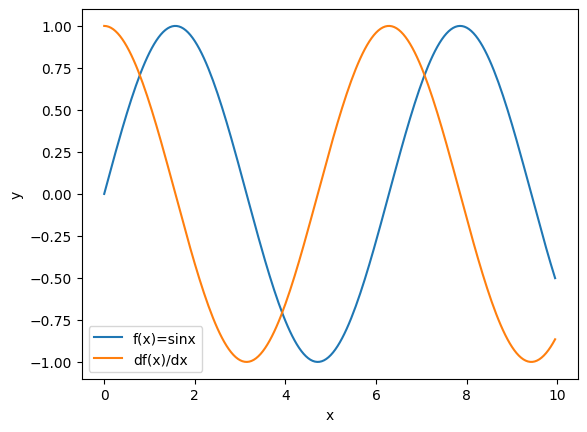

In [83]:
# 练习 5 绘制
plt.xlabel('x')
plt.ylabel('y')
axe = plt.subplot(1, 1, 1)
axe.plot(x, f_2(x), label='f(x)=sinx')
axe.plot(x, y, label='df(x)/dx')
axe.legend()
plt.show()

[Discussions](https://discuss.d2l.ai/t/1757)
